In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy .linalg import svd
import torch
from torch import nn
import opinf
import math
from IPython.display import clear_output

%load_ext autoreload
%autoreload 2

/mnt/d/PIML/venv/lib/python3.10/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
%reload_ext autoreload
import helper_funcs as hf

#### 1D Burger's Equation Data

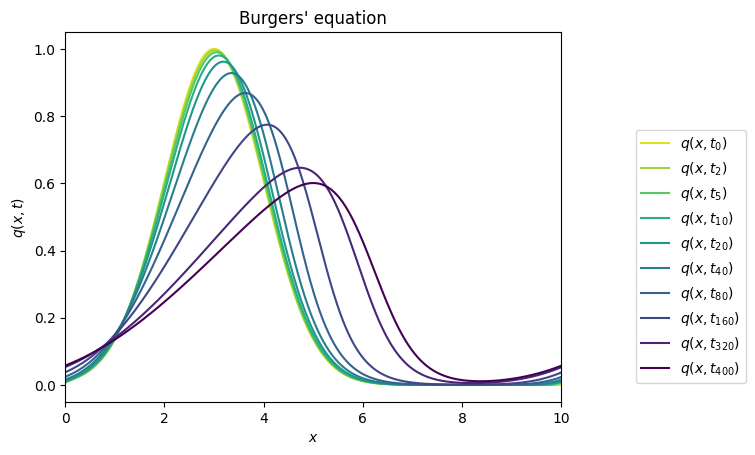

In [3]:
"""
This file was built to solve numerically 1D Burgers' equation wave equation with the FFT. The equation corresponds to :

$\dfrac{\partial u}{\partial t} + \mu u\dfrac{\partial u}{\partial x} = \nu \dfrac{\partial^2 u}{\partial x^2}$

where
 - u represent the signal
 - x represent the position
 - t represent the time
 - nu and mu are constants to balance the non-linear and diffusion terms.

Copyright - © SACHA BINDER - 2021
"""

############## MODULES IMPORTATION ###############
import numpy as np
from scipy.integrate import odeint


############## SET-UP THE PROBLEM ###############

mu = 1
nu = 0.20 #kinematic viscosity coefficient

#Spatial mesh
L_x = 10 #Range of the domain according to x [m]
dx = 0.01 #Infinitesimal distance
N_x = int(L_x/dx) #Points number of the spatial mesh
X = np.linspace(0,L_x,N_x) #Spatial array

#Temporal mesh
L_t = 8 #Duration of simulation [s]
dt = 0.01  #Infinitesimal time
N_t = int(L_t/dt) #Points number of the temporal mesh
T = np.linspace(0,L_t,N_t) #Temporal array

#Wave number discretization
k = 2*np.pi*np.fft.fftfreq(N_x, d = dx)


#Def of the initial condition
u0 = np.exp(-(X-3)**2/2) #Single space variable fonction that represent the wave form at t = 0
# viz_tools.plot_a_frame_1D(X,u0,0,L_x,0,1.2,'Initial condition')

############## EQUATION SOLVING ###############

#Definition of ODE system (PDE ---(FFT)---> ODE system)
def burg_system(u,t,k,mu,nu):
    #Spatial derivative in the Fourier domain
    u_hat = np.fft.fft(u)
    u_hat_x = 1j*k*u_hat
    u_hat_xx = -k**2*u_hat

    #Switching in the spatial domain
    u_x = np.fft.ifft(u_hat_x)
    u_xx = np.fft.ifft(u_hat_xx)

    #ODE resolution
    u_t = -mu*u*u_x + nu*u_xx
    return u_t.real


#PDE resolution (ODE system resolution)
Q = odeint(burg_system, u0, T, args=(k,mu,nu,), mxstep=5000).T



############## PLOT ###############
hf.plot_heat_data(Q,X, "Burgers' equation", BCs=False)

### Operator Inference w/ OpInf Package

r = 9 singular values exceed 99.9999% energy
Shape of Vr: (1000, 9)


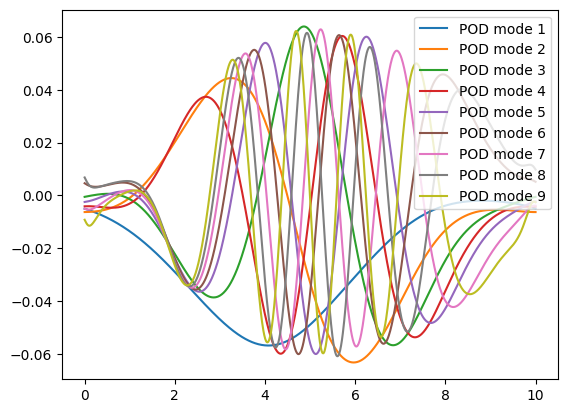

Reduced-order model structure: dq / dt = Aq(t) + H[q(t) ⊗ q(t)]


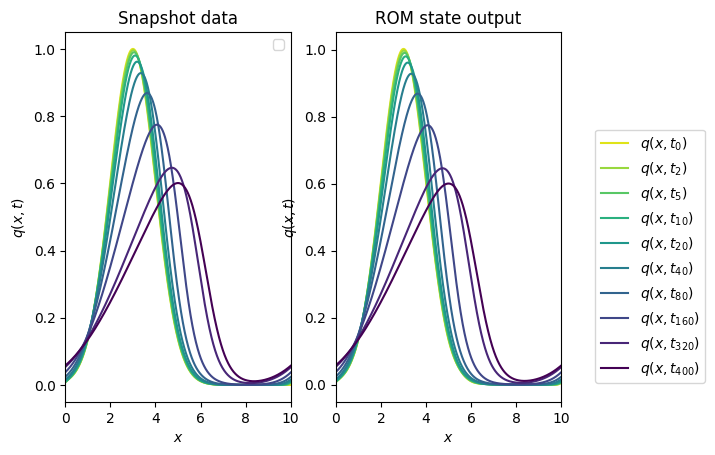

Frobenius Error: 2.74e-01


In [4]:
svdvals = la.svdvals(Q)
kappa = .999999
r = opinf.pre.cumulative_energy(svdvals, kappa, plot=False)
print(f"r = {r:d} singular values exceed {kappa:.4%} energy")
Vr, _ = opinf.pre.pod_basis(Q, r, mode="dense")
print(f"Shape of Vr: {Vr.shape}")
for j in range(Vr.shape[1]):
    plt.plot(X, Vr[:, j], label=f"POD mode {j+1}")
    # plt.plot(x_all[1:-1], Vr[:,j], label=f"POD mode {j+1}")
plt.legend(loc="upper right")
plt.show()
Qdot = opinf.pre.ddt_uniform(Q, dt, order=6)
rom = opinf.ContinuousOpInfROM("AH")
print(rom)
rom.fit(basis=Vr, states=Q, ddts=Qdot)
rom.fit(Vr, Q, Qdot, solver=opinf.lstsq.L2Solver(regularizer=1e-2))
Q_ROM_Opinf = rom.predict(Q[:, 0], T, method="BDF", max_step=dt)
fig, [ax1, ax2] = plt.subplots(1, 2)
hf.plot_heat_data(Q,X, "Snapshot data",BCs=False, ax=ax1)
hf.plot_heat_data(Q_ROM_Opinf, X, "ROM state output", BCs=False, ax=ax2)
ax1.legend([])
plt.show()

print(f"Frobenius Error: {hf.frobenius_norm_error(Q, Q_ROM_Opinf):.2e}")

### Operator Inference w/ Torch

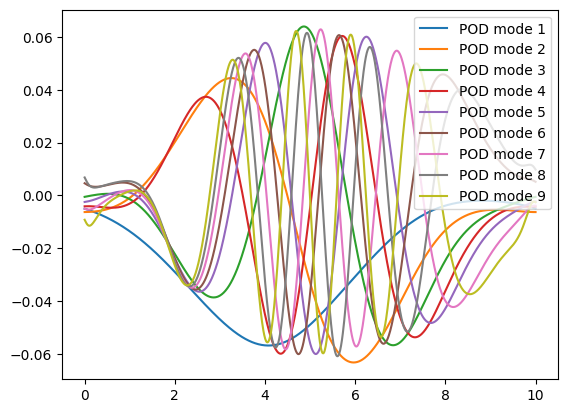

In [5]:
U, s, VT = svd(Q)
r = hf.optimal_svd_vecs(0.999999, s)
Vr = U[:, :r]

for j in range(Vr.shape[1]):
    plt.plot(X, Vr[:, j], label=f"POD mode {j+1}")
    plt.legend(loc="upper right")


In [6]:
Q_hat = hf.get_reduced_matrices(Q, Vr)
Q_dot = hf.get_time_derivatives(Q_hat, dt)

print("Original Data shape: ", Q.shape)
print("Reduced Data shape: ", Q_hat.shape)

model = hf.OpInfs_torch(Q_dim=Q_hat.shape, model_type="LiB")

optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-07)
loss_fn = lambda x, y : torch.sum(torch.square(x-y))
data = [Q_dot, Q_hat[:, :Q_hat.shape[1]-1] ]


hf.train_loop(optimizer, loss_fn, data, model, n_epochs = 10000)

Q_ROM_Torch = model.predict(Q_hat[:, 0], Vr, T)

Original Data shape:  (1000, 800)
Reduced Data shape:  (9, 800)
Loss : 0.0006784572615288198
Loss : 0.00018251851724926382
Loss : 0.0001447537651984021
Loss : 0.0031402860768139362
Loss : 0.001260597724467516


Frobenius Error:  0.3152194661853388


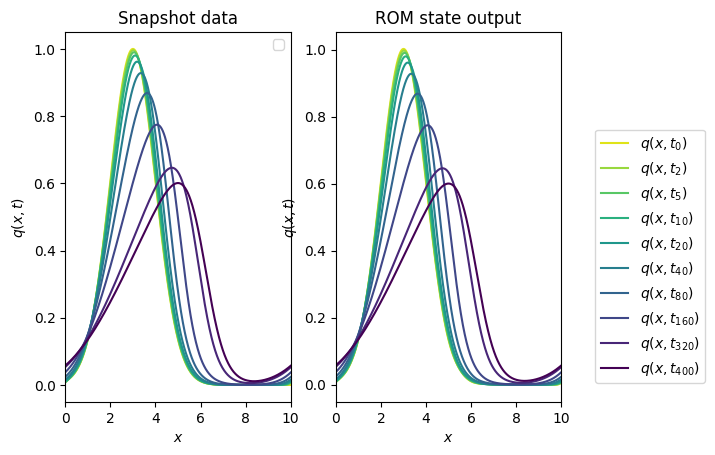

In [7]:
print("Frobenius Error: ", hf.frobenius_norm_error(Q, Q_ROM_Torch))
fig, [ax1, ax2] = plt.subplots(1, 2)
hf.plot_heat_data(Q,X, "Snapshot data",BCs=False, ax=ax1)
hf.plot_heat_data(Q_ROM_Torch, X, "ROM state output", BCs=False, ax=ax2)
ax1.legend([])
plt.show()

### Operator Inference from Scratch

Original Data shape:  (1000, 800)
Reduced Data shape:  (9, 800)
shape of Operators_inf : (54, 9)


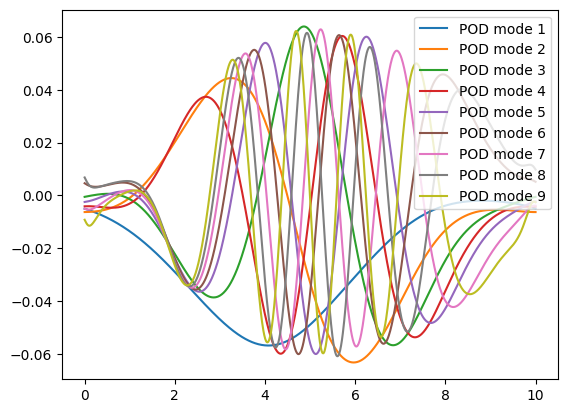

In [8]:
U, s, VT = svd(Q)
r = hf.optimal_svd_vecs(0.999999, s)
Vr = U[:, :r]

for j in range(Vr.shape[1]):
    plt.plot(X, Vr[:, j], label=f"POD mode {j+1}")
    plt.legend(loc="upper right")

Q_hat = hf.get_reduced_matrices(Q, Vr)
Q_dot = hf.get_time_derivatives(Q_hat, dt)
Q_hat2 = hf.x_2(Q_hat)

D_hat = Q_hat
D_hat = np.append(D_hat, Q_hat2, axis=0)

print("Original Data shape: ", Q.shape)
print("Reduced Data shape: ", Q_hat.shape)

#Getting Operators

b = Q_dot.T
a = D_hat[:, 1:].T
lamb = 0.0001
opers_inf, _, _, _ = np.linalg.lstsq(a.T.dot(a) + lamb*np.identity(a.shape[1]), a.T.dot(b), rcond=None)
print("shape of Operators_inf :",opers_inf.shape)
opers_inf = opers_inf.T

(800,)


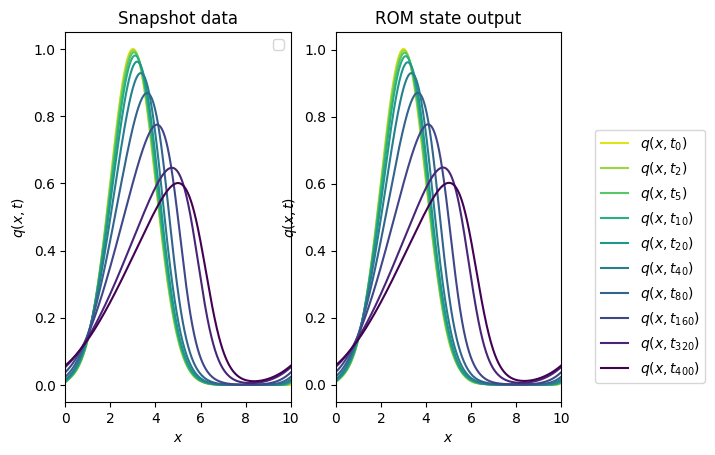

Fronebius Error:  1.2244981209361792


In [10]:
A_inf = opers_inf[:, :r]
B_inf = opers_inf[:, r:]

Q_hat_0 = Q_hat[:, 0]

print(T.shape)
Q_inf_scratch = hf.predict_from_scratch(A_inf=A_inf, B_inf=B_inf, q_0_hat=Q_hat_0, Vr=Vr, t=T)

fig, [ax1, ax2] = plt.subplots(1, 2)
hf.plot_heat_data(Q,X, "Snapshot data",BCs=False, ax=ax1)
hf.plot_heat_data(Q_inf_scratch, X, "ROM state output", BCs=False, ax=ax2)
ax1.legend([])
plt.show()

print("Fronebius Error: ", hf.frobenius_norm_error(Q, Q_inf_scratch))

### Comparision

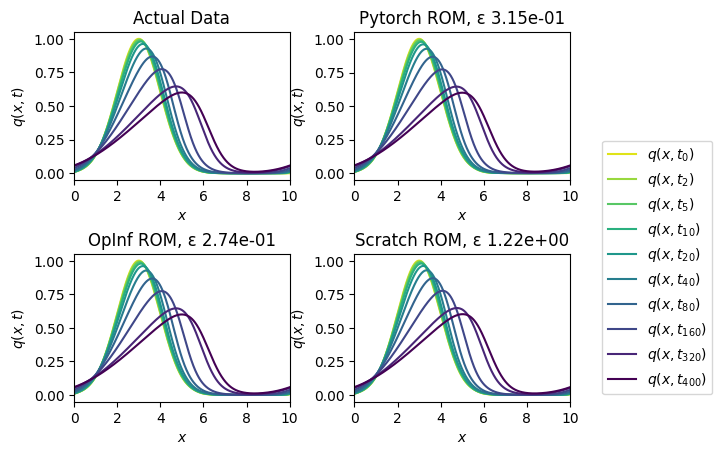

In [11]:
hf.compare(q_0=Q[:, 0], Vr=Vr, Q_data=Q, rom=rom, torch_rom=model, A_inf=A_inf, B_inf=B_inf, x_all=X, t=T)

#### Different Regularization Values

##### Torch


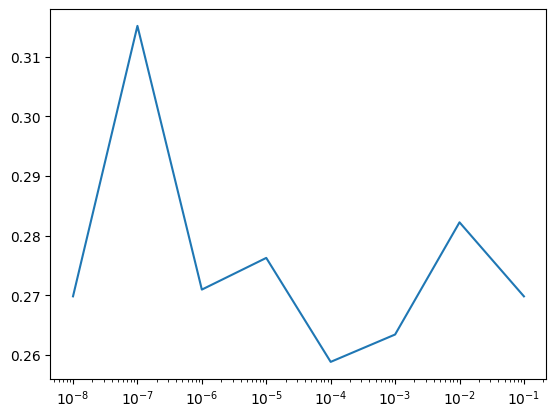

In [12]:
regs = np.logspace(np.log10(0.00000001), np.log10(0.1), 8) # Lambda Values

loss_fn = lambda x, y : torch.sum(torch.square(x-y))

data = [Q_dot, Q_hat[:, :Q_hat.shape[1]-1] ]
loss_reg = []

for reg in regs:
    
    Q_hat = hf.get_reduced_matrices(Q, Vr)
    Q_dot = hf.get_time_derivatives(Q_hat, dt)
    
    loss_fn = lambda x, y : torch.sum(torch.square(x-y))

    print("Lambda: ", reg)
    
    model = hf.OpInfs_torch(Q_dim=Q_hat.shape, model_type="LiB")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=reg)
    hf.train_loop(optimizer, loss_fn, data.copy(), model, n_epochs = 10000)

    Q_ROM_Torch = model.predict(Q_hat[:, 0], Vr, T)
    
    error = hf.frobenius_norm_error(Q.copy(), Q_ROM_Torch)
    clear_output(wait=True)
    loss_reg.append([error, reg])
    del model
    del optimizer

plt.semilogx(np.array(loss_reg)[:, 1], np.array(loss_reg)[:, 0])
plt.show()

##### OpInf Package

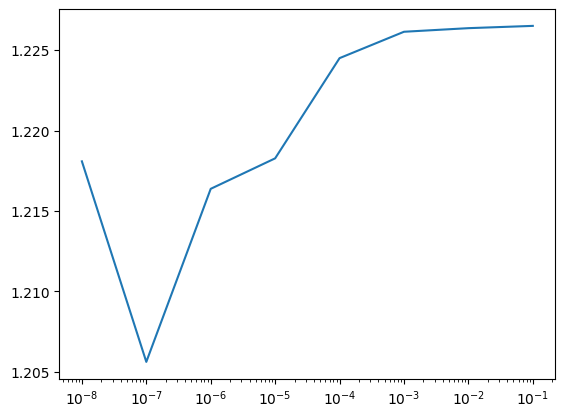

In [13]:
loss_reg = []
for reg in regs:
    Q_hat = hf.get_reduced_matrices(Q, Vr)
    Q_dot = hf.get_time_derivatives(Q_hat, dt)
    Q_hat2 = hf.x_2(Q_hat)

    D_hat = Q_hat
    D_hat = np.append(D_hat, Q_hat2, axis=0)

    b = Q_dot.T
    a = D_hat[:, 1:].T
    lamb = reg
    opers_inf, _, _, _ = np.linalg.lstsq(a.T.dot(a) + lamb*np.identity(a.shape[1]), a.T.dot(b), rcond=None)
    
    opers_inf = opers_inf.T

    A_inf = opers_inf[:, :r]
    B_inf = opers_inf[:, r:]

    Q_hat_0 = Q_hat[:, 0]

    Q_inf_scratch = hf.predict_from_scratch(A_inf=A_inf, B_inf=B_inf, q_0_hat=Q_hat_0, Vr=Vr, t=T)
    loss_reg.append([hf.frobenius_norm_error(Q, Q_inf_scratch), reg])

plt.semilogx(np.array(loss_reg)[:, 1], np.array(loss_reg)[:, 0])
plt.show()
    
